#### On-Policy Temporal Difference(0) based Control : **SARSA** [without Exploring Starts by making policy soft (i.e, $\pi(a,x)>0$) like $\epsilon$-greedy policy]

State-action Value matrix after 200000 iterations:
[[0.77981734 0.85376678 0.9283935  0.        ]
 [0.71685658 0.         0.59738955 0.        ]
 [0.64841964 0.59121094 0.52921948 0.24638547]] 

[[ 3.  3.  3. -1.]
 [ 0. nan  0. -1.]
 [ 0.  1.  0.  1.]]


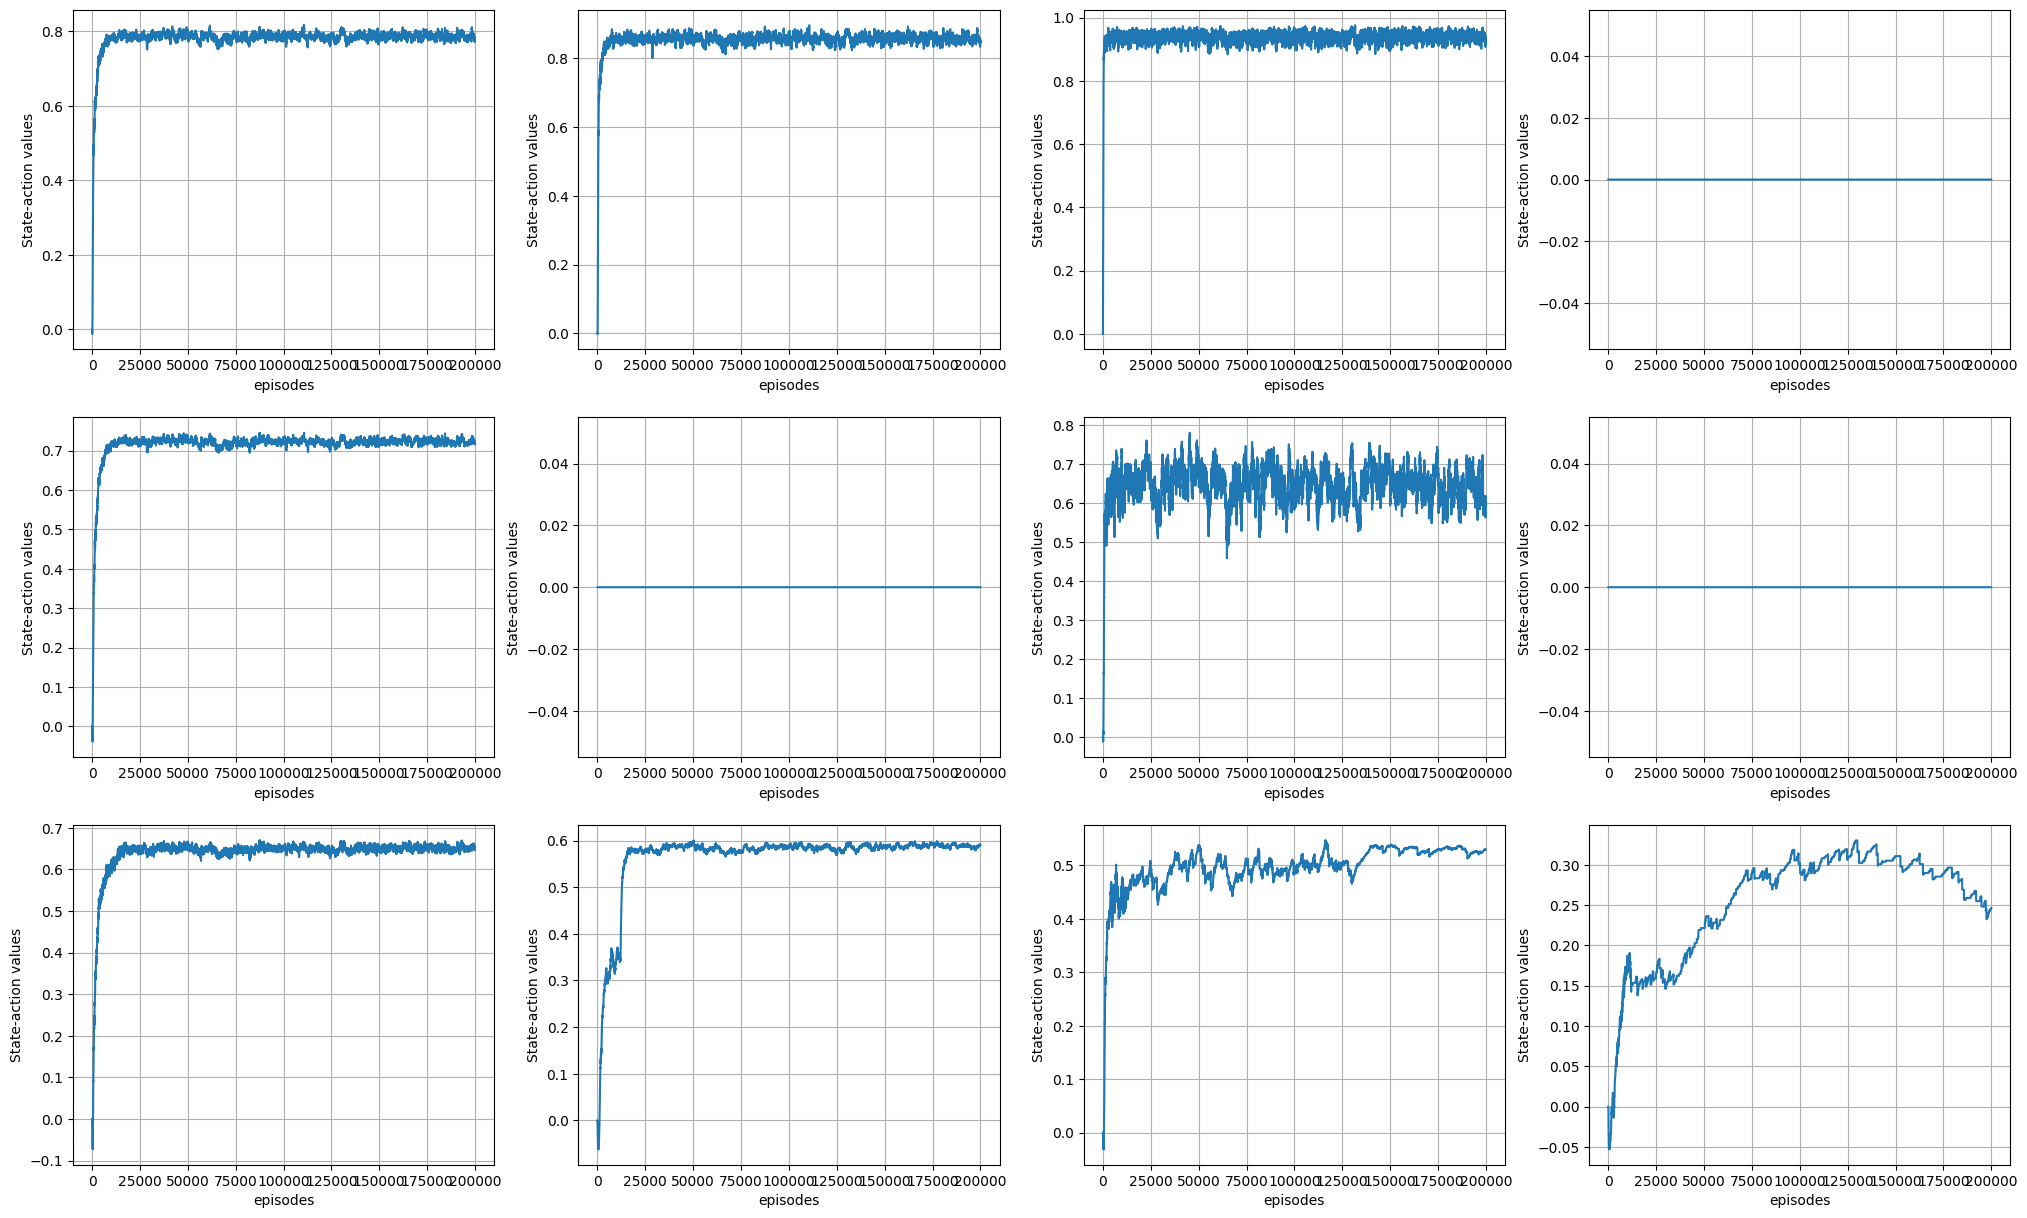

In [2]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
np.set_printoptions(suppress=True)  # to aviod scientific notation while printing numpy array
sys.path.append('..')

from environment import Gridworld

env = Gridworld()
gamma = 0.999 # discount factor
alpha = 0.01
epsilon = 0.2 # this is the probability, that we'll not take the action from given policy but we'll take random actions
"""If epsilon=0, means we have greedy policy and if epsilon=1, means we'll only take random action. Thats, why we call it exploration parameter"""

q = np.zeros((4, env.world_row*env.world_column)) # Defining an empty state-action value matrix
q_plot = np.zeros((12,1)) # store data for plotting

# INPUT -> TD(0) method is initialized with a random policy, {up=0, left=1, down=2, right=3}
policy = np.random.randint(0, 4, size=(env.world_row, env.world_column)).astype(np.float32) # Initial random Policy 
policy[1,1] = np.NaN # policy for block
policy[0,3] = -1 # policy for stairs
policy[1,3] = -1 # policy for goal state

non_greedy_prob = epsilon/env.no_action # Probability of all non-greedy action
greedy_prob = 1 - epsilon + non_greedy_prob # Probability of all greedy action

tot_episodes = 200000 # no of eposides
time_step_for_task = 20 # time steps required to perform a task in one episode

for current_episode in range(tot_episodes):
    robot_current_state = env.reset() # Reset and return the first observation
    
    #greedy_action = int(policy[robot_current_state[0],robot_current_state[1]]) # exploitative action
    greedy_action = np.argmax(q[:,robot_current_state[0]*4 + robot_current_state[1]]) # exploitative action

    # Take the action using epsilon-greedy
    weight_array = non_greedy_prob*np.ones((env.no_action)) # The weights of all non-greedy actions are equal to non-greedy probability
    weight_array[greedy_action] = greedy_prob # Now, we replace the weight of our greedy-action with greedy probability

    # Take the action using epsilon-greedy Policy
    """Choose an action that has maximal state-action value most of the time, but with probability ε select an action(out of all actions) at random"""
    action = int(np.random.choice(env.no_action,1,p=weight_array)) # u_{k} 

    # Now we can run for some time step within the episode
    for step_time in range(time_step_for_task): 
        next_position = env.step(action) # perform this action
        
        state_reward = env.reward[next_position[0],next_position[1]] # state reward obtained (for state at t+1)   

        # One-step TD(0) update
        current_y = 4*robot_current_state[0] + robot_current_state[1] 
        q_current_xk = q[action,current_y] # q(x_{k},u_{k}) -> current

        # new_greedy_action = int(policy[env.position[0],env.position[1]]) # action that has maximum estimated state-action value
        new_greedy_action = np.argmax(q[:,next_position[0]*4 + next_position[1]]) # exploitative action

        # Take the action using epsilon-greedy
        weight_array = non_greedy_prob*np.ones((env.no_action)) # The weights of all non-greedy actions are equal to non-greedy probability
        weight_array[new_greedy_action] = greedy_prob # Now, we replace the weight of our greedy-action with greedy probability

        # Take the action using epsilon-greedy Policy
        """Choose an action that has maximal state-action value most of the time, but with probability ε select an action(out of all actions) at random"""
        new_action = int(np.random.choice(env.no_action,1,p=weight_array)) # u_{k+1}

        new_y = 4*next_position[0] + next_position[1]
        q_current_xk1 = q[new_action,new_y] # q(x_{k+1},u_{k+1}) -> current
        
        rk1 = state_reward # r_{k+1}

        q[action,current_y] += alpha*(rk1 + gamma*q_current_xk1 - q_current_xk) # q(x_{k},u_{k}) -> new

        # Policy Update (Improvement)
        if policy[robot_current_state[0],robot_current_state[1]] != -1:
            policy[robot_current_state[0],robot_current_state[1]] = action #np.argmax(q[:,current_y]) #action

        robot_current_state = next_position # Update robot current position (from x_{t} to x_{t+1})
        action = new_action # Update robot current action (from u_{t} to u_{t+1})

        if env.state_matrix[next_position[0],next_position[1]] == 1:
            break
 
    if current_episode % 10 == 0: # saving every 50th action-value
        q_plot = np.hstack((q_plot,np.amax(q, axis=0).reshape(12,1))) # save state values for graph plotting

# Arranging final state-action values in matrix form
q_final = np.zeros((env.world_row, env.world_column))
q_avg_final = np.amax(q, axis=0) # saving maximum state-action values of all 4 actions 
for j in range(env.world_row):
    for k in range(env.world_column):
        q_final[j,k] = q_avg_final[j*4 + k]

# Time to check the utility matrix obtained
print("State-action Value matrix after " + str(tot_episodes) + " iterations:")
print(q_final,'\n')
print(policy)

# Convergences Plot of state-values
plt.figure(figsize=(25,15))
for i in range(1,(env.world_row*env.world_column)+1):
    plt.subplot(env.world_row, env.world_column, i) # math.ceil() will round the value to upper limit
    plt.plot(np.arange(0,tot_episodes+1,10),q_plot[i-1,:])
    plt.grid()
    plt.ylabel('State-action values')
    plt.xlabel('episodes')
plt.show()

#### Off-Policy Temporal Difference(0) based Control : **Q-learning**

**Q-learning** followed a behaviour policy $\mu$ which is sub-optimal and estimated the optimal policy $\pi^{*}$ starting from a random policy $\pi$.

State-action Value matrix after 200000 iterations:
[[0.84476538 0.90132758 0.94907807 0.        ]
 [0.79702523 0.         0.61720399 0.        ]
 [0.73881334 0.68488871 0.63597039 0.43893771]] 

[[ 3.  3.  2. -1.]
 [ 0. nan  0. -1.]
 [ 0.  1.  1.  1.]]


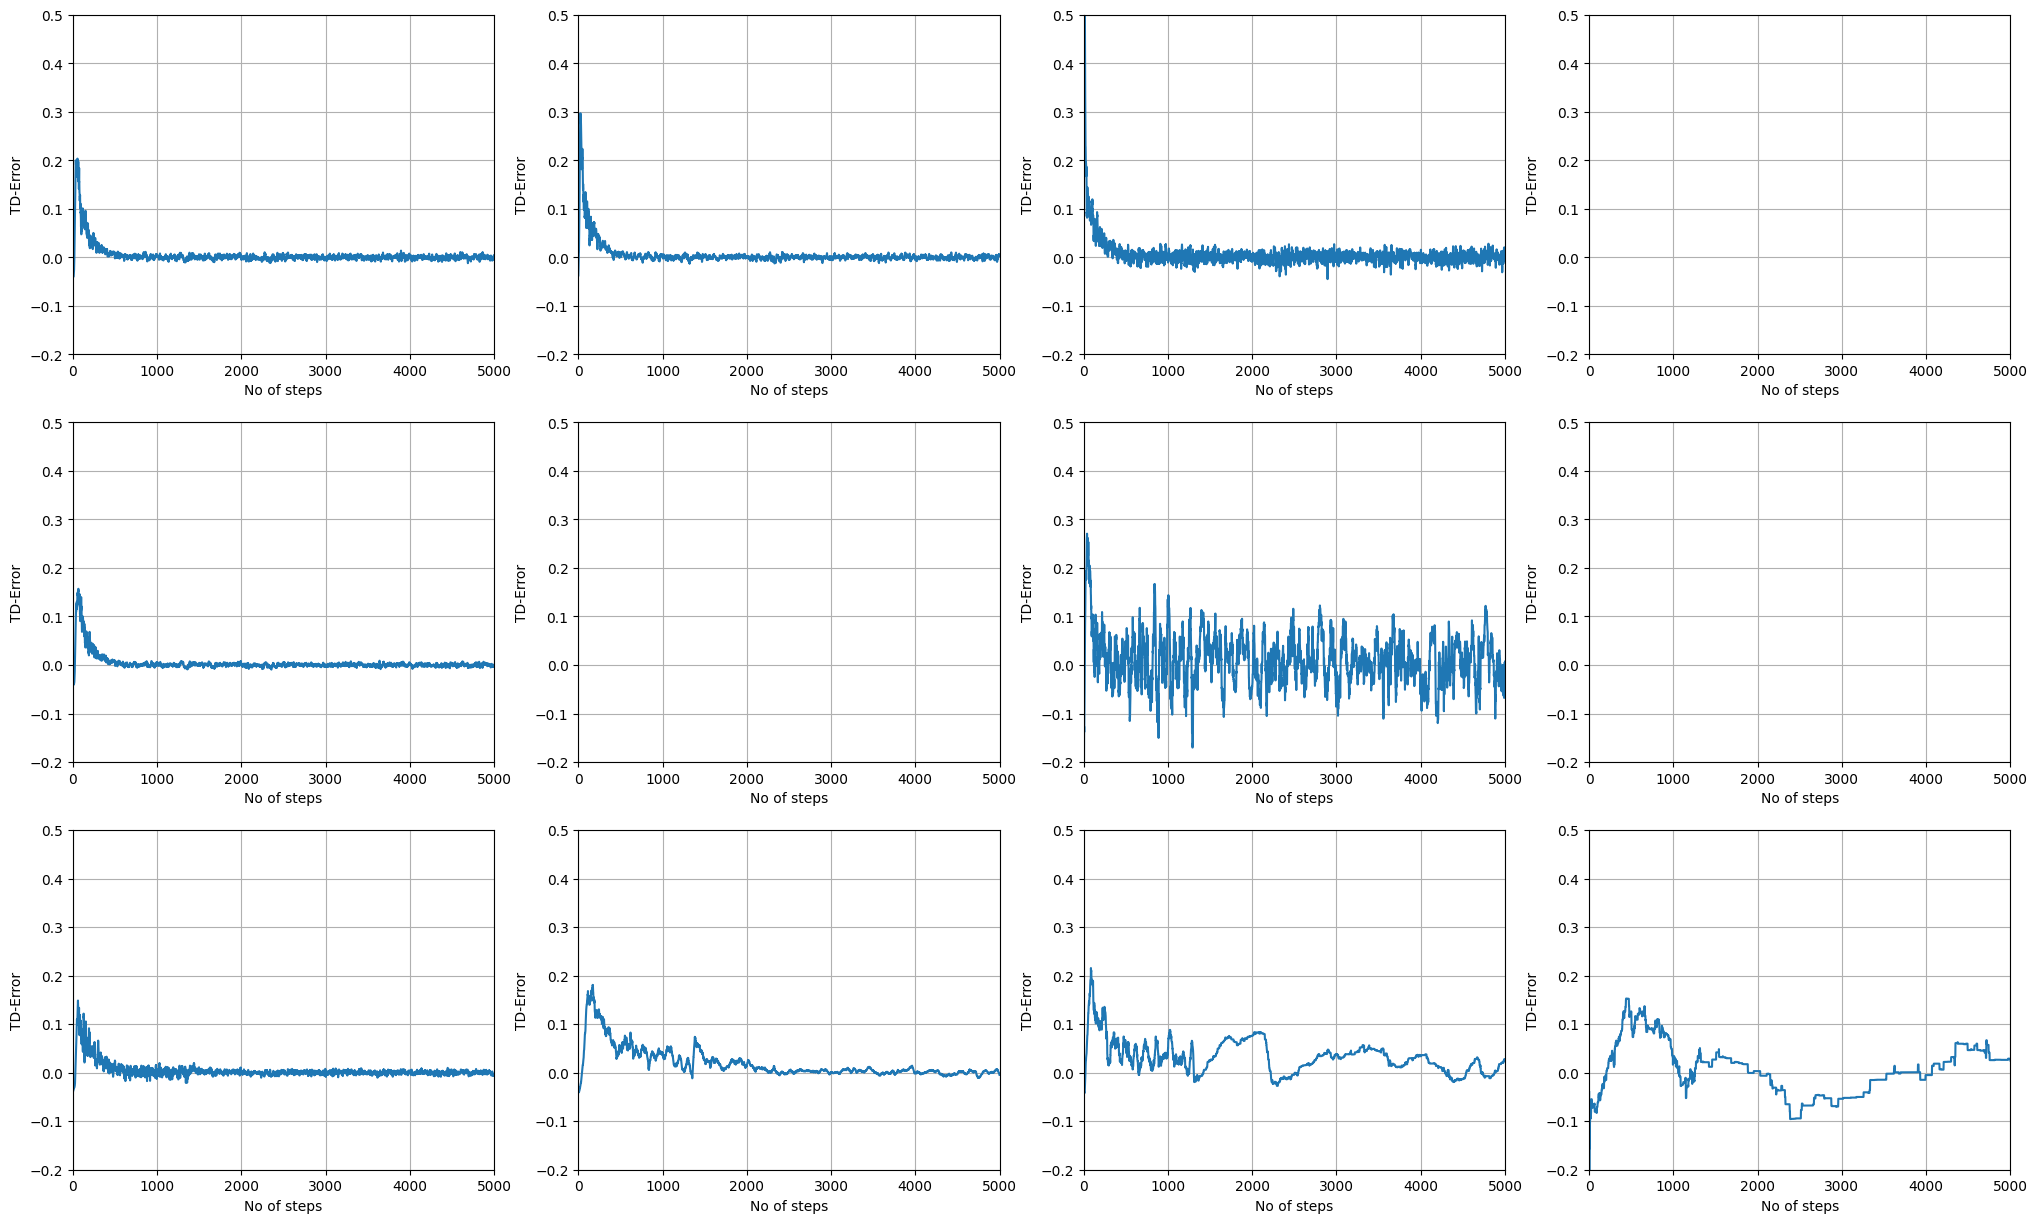

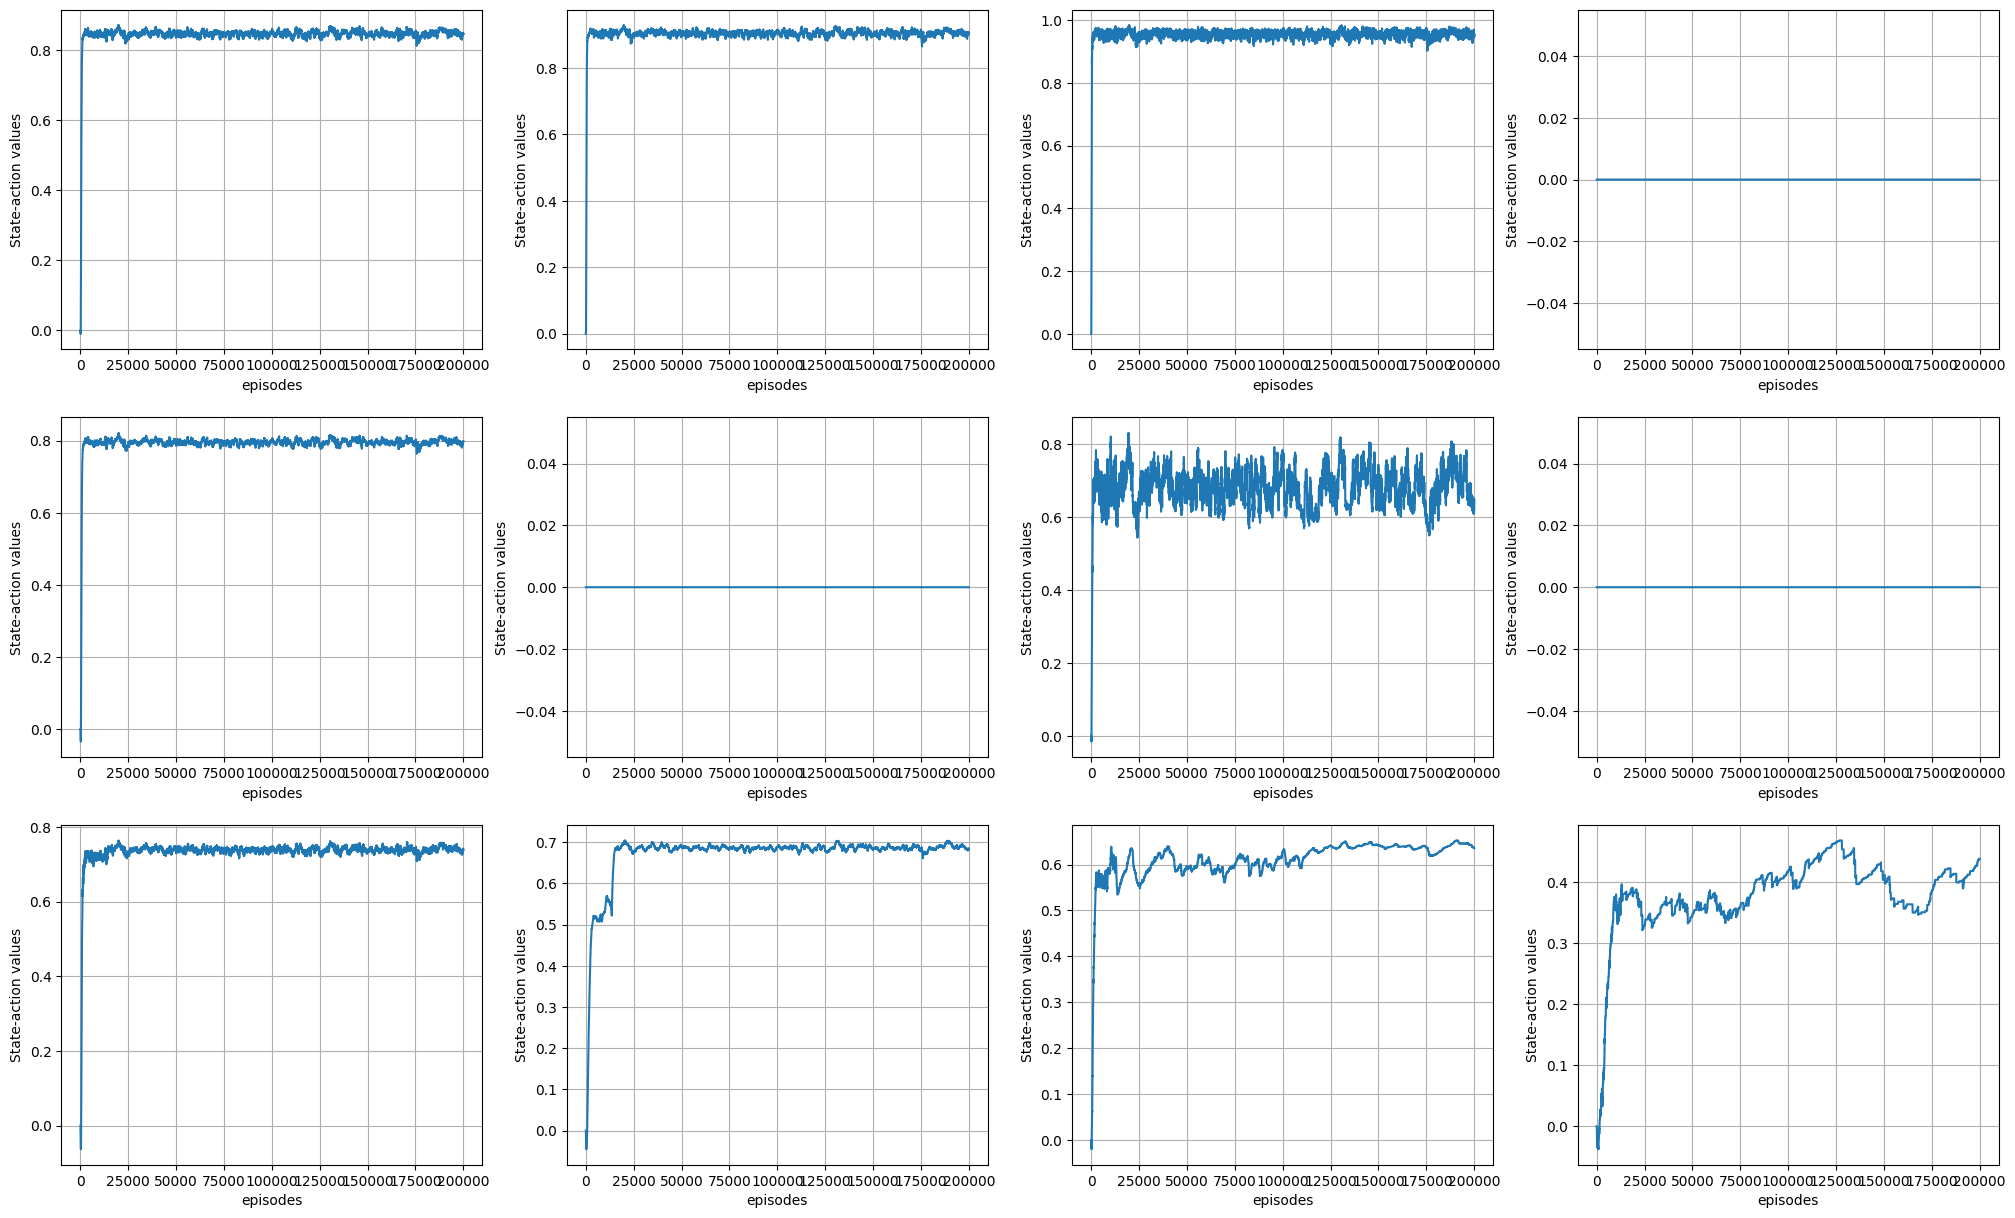

In [ ]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
np.set_printoptions(suppress=True)  # to aviod scientific notation while printing numpy array
sys.path.append('..')

from environment import Gridworld

env = Gridworld()
gamma = 0.999 # discount factor
alpha = 0.01 # constant step size
epsilon = 0.2 # this is the probability, that we'll not take the action from given policy but we'll take random actions
"""If epsilon=0, means we have greedy policy and if epsilon=1, means we'll only take random action. Thats, why we call it exploration parameter"""

q = np.zeros((4, env.world_row*env.world_column)) # Defining an empty state-action value matrix
q_plot = np.zeros((12,1)) # store data for plotting

# INPUT -> TD(0) method is initialized with a random policy, {up=0, left=1, down=2, right=3}
policy = np.random.randint(0, 4, size=(env.world_row, env.world_column)).astype(np.float32) # Initial random Policy 
policy[1,1] = np.NaN # policy for block
policy[0,3] = -1 # policy for stairs
policy[1,3] = -1 # policy for goal state

non_greedy_prob = epsilon/env.no_action # Probability of all non-greedy action
greedy_prob = 1 - epsilon + non_greedy_prob # Probability of all greedy action

tot_episodes = 200000 # no of eposides
time_step_for_task = 20 # time steps required to perform a task in one episode

TD_error = [[],[],[],[],[],[],[],[],[],[],[],[]]
Avg_TD_error = [[],[],[],[],[],[],[],[],[],[],[],[]]

for current_episode in range(tot_episodes):
    robot_current_state = env.reset() # Reset and return the first observation

    # Now we can run for some time step within the episode
    for step_time in range(time_step_for_task): 
        #greedy_action = int(policy[robot_current_state[0],robot_current_state[1]])
        greedy_action = np.argmax(q[:, robot_current_state[0]*4 + robot_current_state[1]])

        # Take the action using epsilon-greedy
        weight_array = non_greedy_prob*np.ones((env.no_action)) # The weights of all non-greedy actions are equal to non-greedy probability
        weight_array[greedy_action] = greedy_prob # Now, we replace the weight of our greedy-action with greedy probability

        # Take the action using epsilon-greedy Policy
        """Choose an action that has maximal state-action value most of the time, but with probability ε select an action(out of all actions) at random"""
        action = int(np.random.choice(env.no_action, 1, p=weight_array)) # u_{k} 

        next_position = env.step(action) # perform this action
        
        state_reward = env.reward[next_position[0], next_position[1]] # state reward obtained (for state at t+1)   

        # One-step TD(0) update
        current_y = 4*robot_current_state[0] + robot_current_state[1] 
        q_current_xk = q[action, current_y] # q(x_{k},u_{k}) -> current
        
        rk1 = state_reward # r_{k+1}

        q[action,current_y] += alpha*(rk1 + gamma*np.max(q[:,4*next_position[0] + next_position[1]])  - q_current_xk) # q(x_{k},u_{k}) -> new

        TD_error[current_y].append(rk1 + gamma*np.max(q[:,4*next_position[0] + next_position[1]])  - q_current_xk)
        
        # Policy Update (Improvement)
        if policy[robot_current_state[0], robot_current_state[1]] != -1:
            policy[robot_current_state[0], robot_current_state[1]] = action #np.argmax(q[:,current_y]) # making greedy choices
        robot_current_state = next_position # Update robot current position (from x_{t} to x_{t+1})

        if env.state_matrix[next_position[0], next_position[1]] == 1:
            break

    if current_episode % 10 == 0: # saving every 50th action-value
        q_plot = np.hstack((q_plot, np.amax(q, axis=0).reshape(12,1))) # save state values for graph plotting
        
        for i in range(len(TD_error)):
            if len(TD_error[i]) != 0:
                Avg_TD_error[i].append(np.mean(TD_error[i][-100:]))
    
# Arranging final state-action values in matrix form
q_final = np.zeros((env.world_row, env.world_column))
q_avg_final = np.amax(q, axis=0) # saving maximum state-action values of all 4 actions 
for j in range(env.world_row):
    for k in range(env.world_column):
        q_final[j,k] = q_avg_final[j*4 + k]

# Time to check the utility matrix obtained
print("State-action Value matrix after " + str(tot_episodes) + " iterations:")
print(q_final,'\n')
print(policy)

# Average TD-Error Plot
plt.figure(figsize=(25,15))
for i in range(1,(env.world_row*env.world_column)+1):
    plt.subplot(env.world_row, env.world_column, i) # math.ceil() will round the value to upper limit
    plt.plot(range(len(Avg_TD_error[i-1])),Avg_TD_error[i-1],label ='TD-Error')
    plt.grid()
    plt.xlabel('No of steps')
    plt.ylabel('TD-Error')
    plt.xlim([0,5000])
    plt.ylim([-0.2, 0.5])

# Convergences Plot of state-values
plt.figure(figsize=(25,15))
for i in range(1,(env.world_row*env.world_column)+1):
    plt.subplot(env.world_row, env.world_column, i) # math.ceil() will round the value to upper limit
    plt.plot(np.arange(0,tot_episodes+1,10),q_plot[i-1,:])
    plt.grid()
    plt.ylabel('State-action values')
    plt.xlabel('episodes')
plt.show()

#### n-Step SARSA

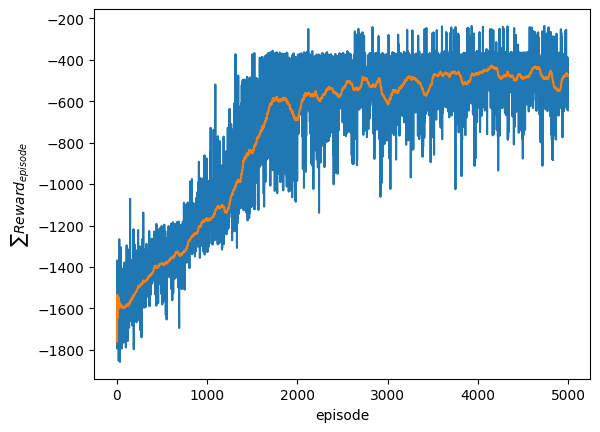

In [1]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
np.set_printoptions(suppress=True)  # to aviod scientific notation while printing numpy array
sys.path.append('..')

from environment import PendulumEnv

env = PendulumEnv()
n = 10
gamma = 0.9 # discount factor
alpha = 0.1 # constant step size
epsilon = 0.1 # this is the probability, that we'll not take the action from given policy but we'll take random actions
"""If epsilon=0, means we have greedy policy and if epsilon=1, means we'll only take random action. Thats, why we call it exploration parameter"""

q = np.zeros([env.d_omega, env.d_torque, env.d_theta * env.d_theta]) # Defining an empty state-action value matrix (layer=omega, row=torque, column=x*y)

# INPUT -> TD(0) method is initialized with a random policy
policy = np.random.randint(0, env.d_torque, size=(env.d_omega, env.d_theta, env.d_theta)).astype(int) # Initial random Policy (layer,row,column)

cumulative_reward_list = []
avg_reward_history = []

non_greedy_prob = epsilon / env.d_torque # Probability of all non-greedy action
greedy_prob = 1 - epsilon + non_greedy_prob # Probability of all greedy action

tot_episodes = 5000 # no of eposides
time_step_for_task = 200 # time steps required to perform a task in one episode

gamma_vector = gamma**np.arange(n)

for current_episode in range(tot_episodes):
    discrete_state_list = []
    discrete_action_list = []
    reward_list = []

    initial_state = env.reset() # Reset and return the first observation

    discrete_state = tuple(env.discretize_state(initial_state))
    discrete_state_list.append(discrete_state) # Saving initial state, x_{0}

    discrete_action = policy[discrete_state[2], discrete_state[0], discrete_state[1]] # some initial action, u_{0} ~ pi(.|x_{0}) in discrete form
    discrete_action_list.append(tuple([discrete_action])) # Saving initial action, u_{0}

    # Now we can run for some time step within the episode
    for k in range(time_step_for_task + n - 2): 
        
        continuous_action = env.continualize_action(discrete_action)

        continuous_state,reward = env.step(continuous_action) # performing action u_{k} and observing x_{k+1} and r_{k+1}
        
        discrete_state = tuple(env.discretize_state(continuous_state))
  
        discrete_state_list.append(discrete_state) # Saving state, x_{k+1}

        reward_list.append(reward) # Saving reward, r_{k+1}

        greedy_action = policy[discrete_state[2], discrete_state[0], discrete_state[1]] # exploitative action

        # Take the action using epsilon-greedy
        weight_array = non_greedy_prob*np.ones((env.d_torque)) # The weights of all non-greedy actions are equal to non-greedy probability
        weight_array[greedy_action] = greedy_prob # Now, we replace the weight of our greedy-action with greedy probability

        # Take the action using epsilon-greedy Policy
        """Choose an action that has maximal state-action value most of the time, but with probability ε select an action(out of all actions) at random"""
        discrete_action = np.random.choice(env.d_torque, 1, p=weight_array)[0] # u_{k+1} 

        discrete_action_list.append(tuple([discrete_action])) # Saving initial action, u_{k+1}
        
        tau = k - n + 1

        # n-step TD(0) update
        if tau >= 0:
            x_1,y_1,omega_1 = discrete_state_list[k+1]

            row_1 = discrete_action_list[k+1]
            column_1 = env.d_theta * x_1 + y_1
            layer_1 = omega_1

            g = sum((gamma_vector * reward_list[tau:tau+n]))
            
            g = g + (gamma**n) * q[layer_1, row_1, column_1] 

            x_2, y_2, omega_2 = discrete_state_list[tau]

            row_2 = discrete_action_list[tau]
            column_2 = env.d_theta * x_2 + y_2
            layer_2 = omega_2

            q[layer_2, row_2, column_2] = q[layer_2, row_2, column_2] + alpha * (g - q[layer_2, row_2, column_2])
            
            policy[omega_2, x_2, y_2] = np.argmax(q[layer_2, :, column_2])

    cumulative_reward_list.append(np.sum(reward_list))
    avg_reward = np.mean(cumulative_reward_list[-100:])
    avg_reward_history.append(avg_reward) 


plt.plot(cumulative_reward_list)
plt.plot(avg_reward_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum Reward_{episode}$")
plt.show()

#### Greedy Execution of above optimal policy
Test the learned optimal policy by pure greedy execution.

In [2]:
import csv

Initial_state = env.reset() # initialize x_0
discrete_state = tuple(env.discretize_state(Initial_state)) # use tuple indexing
discrete_action = policy[discrete_state[2],discrete_state[0],discrete_state[1]]
pendulum_plot = [(initial_state[0],initial_state[1])]
plot_torque = [np.array([0])]

for k in range(200):  
    continuous_action = env.continualize_action(discrete_action)
    continuous_state, reward = env.step(continuous_action)

    pendulum_plot.append((continuous_state[0],continuous_state[1]))
    plot_torque.append(continuous_action)

    discrete_state = tuple(env.discretize_state(continuous_state))
        
    discrete_action = policy[discrete_state[2],discrete_state[0],discrete_state[1]] # exploitative action

# Save the state data as ".csv" for plotting
with open("pendulum_by_n_SARSA.csv",'w') as csvfile:  
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(pendulum_plot) 